# Deep Neural Networks for Image Classification

Author: **Paul A. Beata**  
GitHub: [pbeata](https://github.com/pbeata)

----

_The data used for this project is from the MNIST set of handwritten digits available in the TensorFlow datasets module: [Link to TensorFlow Site](https://www.tensorflow.org/datasets/catalog/mnist)_

This project uses the data set called MNIST for a deep learning application of handwritten digit recognition. The data set provides 70,000 images (each of size 28x28 pixels, no color) of handwritten digits with 1 digit per image. 

The goal of this project is to write an algorithm that detects which digit is written in each input image. Since there are only 10 possible digits {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, this is a classification task with 10 classes. 

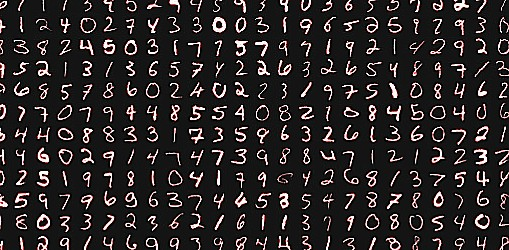

### _Python Modules_

For this deep learning application, we will employ TensorFlow to make use of the Keras neural networks methods.

In [1]:
import numpy as np
import tensorflow as tf
%config Completer.use_jedi = False

The data set for this application comes from the "tensorflow-datasets" module; therefore, if you do not have this installed in your system, you must first run one of the following install commands:

In [116]:
# TensorFlow includes the data provided for the MNIST application that we'll use. 
# It comes with the tensorflow-datasets module, therefore, if you haven't yet, please install the package using:

# option 1 (uncomment and run the next line)
# pip install tensorflow-datasets 

# OR

# option 2 (uncomment and run the next line)
# conda install tensorflow-datasets

In [117]:
import tensorflow_datasets as tfds

These datasets will be stored in the path "C:\Users\*USERNAME*\tensorflow_datasets\" (on Windows). The first time you download a dataset, it is stored in its respective folder, but every other time after that it will be automatically loaded from the copy on your machine. 

### Part 1: Data Preprocessing

Here we will perform two main tasks on the MNIST number recognition dataset:
1. Load the data from the tensorflow-datasets module
2. Split into training, validation, and testing data subsets
3. Scale the data (more specifically, normalize each imahe pixel to the range [0,1])
4. Shuffle the split and scaled data

#### 1. Load MNIST Data

The method tfds.load actually loads a dataset (or downloads and then loads it if it's the first time we are using this data from the tensorflow-datasets modeuls. In this case, we are interesteed in the MNIST data set.

In [3]:
# download or load the MNIST data set from TensorFlow

# mnist_dataset = tfds.load(name='mnist', as_supervised=True)
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

Using the optional input "as_supervised=True" will load the data set in a 2-tuple structure: (input, target). This separates the input data from the target data for us automatically and is simply a matter of convenience.

In [4]:
# once we have loaded the dataset, we can easily extract the training and testing dataset with the built-in references
mnist_train = mnist_dataset['train']
mnist_test  = mnist_dataset['test']

#### 2. Train-Validation-Test Proportions

The data set was originally split into TRAIN and TEST subsets already. First, we can check the percentages of each split here using the "mnist_info" data structure to extract info about the loaded data.

In [5]:
# get the number of train and test samples from the data set
num_train = mnist_info.splits['train'].num_examples
num_test = mnist_info.splits['test'].num_examples
num_total = num_train + num_test

In [6]:
# check the train-test split percentage
percent_train = 100 * num_train / num_total
percent_test = 100 * num_test / num_total

# round the percentages and display them here:
percent_train = np.round(percent_train, 1)
percent_test = np.round(percent_test, 1)
print("Training Data: {p}%".format(p=percent_train))
print("Testing Data:  {p}%".format(p=percent_test))

Training Data: 85.7%
Testing Data:  14.3%


By default, the MNIST data set in TensorFlow has pre-labeled "train" and "test" datasets, but there is no validation subset. Therefore, we will split it on our own here in order to generate a validation subset from the training data.

In [7]:
# specify the fraction of training data that will be reserved for validation (we use 10% here)
validation_fraction = 0.1
num_valid = validation_fraction * num_train

# make sure that the number of validation samples is stored as an integer:
# num_valid = tf.cast(num_valid, tf.int64)
num_valid = int(num_valid)
num_valid

6000

_Note:_ we will perform the actual split after scaling next. This step was only to prepare the relative proportions of each of the data subsets.

#### 3. Scaling the Data

Here we will scale the data in order to make the results more numerically stable. In this case, using image data with pixel values between [0, 255], we will simply normalize each image's pixels such that all the inputs are between 0 and 1 instead.

In [8]:
# custom scaling function that will take an image from MNIST and normalize the pixel value range to [0,1]
def scale(image, label):
    # we make sure the value is cast to a float first
    image = tf.cast(image, tf.float32)
    # since the possible values for the inputs are 0 to 255 (256 different shades of gray)
    # if we divide each element by 255, we would get the desired result: 
    #   --> all elements will be between 0 and 1 
    image /= 255.0
    return image, label

In [9]:
# the method .map() allows us to apply this custom transformation ("scale") to our data set
scaled_train_data = mnist_train.map(scale)
scaled_test_data = mnist_test.map(scale)

#### 4. Shuffle and Perform Split

We use the BUFFER_SIZE parameter here for cases when we're dealing with very large data sets. In those cases, we can't shuffle the whole data set all at once because we can't fit it all in memory. Thus, TensorFlow only stores BUFFER_SIZE number of samples in memory at a time and shuffles them. Note: if BUFFER_SIZE=1, then no shuffling will actually happen and if BUFFER_SIZE >= num samples, then shuffling is uniform across the data set. Choosing a BUFFER_SIZE in between is a computational optimization to approximate uniform shuffling. There is a shuffle method already available and we just need to specify the buffer size to use it here.

**Shuffle**

In [10]:
# choose the buffer size for shuffling the data: 10% of the training data set size
buffer_fraction = 0.10
BUFFER_SIZE = int(buffer_fraction * num_train)
BUFFER_SIZE

6000

In [11]:
# shuffle the scaled training data
shuffled_scaled_train_data = scaled_train_data.shuffle(BUFFER_SIZE)

**Split**

Our validation data will be equal to 10% of the training set, which we've already calculated above.

In [12]:
# we use the .take() method to take as many samples as we need for the validation set
validation_data = shuffled_scaled_train_data.take(num_valid)

In [13]:
# Similarly, the training data will be everything else leftover:
#   so, we skip as many samples as there are in the validation set.
train_data = shuffled_scaled_train_data.skip(num_valid)

We can also take this opportunity to batch the training data. This is helpful during training because we will be able to iterate over the different batches in the training data set.

In [14]:
# specify the batch size
BATCH_SIZE = 100

# batch the training data
train_data = train_data.batch(BATCH_SIZE)

In [15]:
# NOTE: for the validation and testing data, we will simply use the number of samples as the batch size for each 
validation_data = validation_data.batch(num_valid)
test_data = scaled_test_data.batch(num_test)

In [16]:
# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

### Part 2: Deep Learning Model

First, we will outline the model to set up ML algorithm for training.

In [17]:
# check the features from our mnist_info data structure to understand the input and output we are dealing with:
mnist_info.features.keys

<bound method FeaturesDict.keys of FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})>

The MNIST data set contains thousands of images comprised of pixels which define each handwritten digit. We can see here that the "image" object is a 28x28 tensor and the output ("label") has 10 classes. In other words, the input size for each image in the set is a collection of 28\*28 = 784 pixels and there the output size is 10 for the 10 possible digits to be predicted by the algorith: {0, 1, ..., 9}.

In [18]:
# we can define the input and output size of our neural net using the info above from mnist_info:
input_size = (28, 28, 1)  # shape of each "image"
output_size = 10          # num_classes for the "label"

One of the hyperparameters that we can optimize for the neueral network is the size of the hidden layers. In this application, we will use a single size for all the layers. However, since we don't know the optimal hidden layer size, we will perform an optimization to try and find the best one. 

In [21]:
# early stopping criteria: increase the patience a little
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

**Model Definition**

* Use two hidden layers to begin (before we optimize)
* Use the first hidden layer size from the list as a test
* Use the relu activation function for each layers before optimizing

In [30]:
# choose a hidden layer size (we know from previous work that a width of 50 works well)
width = 50

# define each layer of the NN model
model = tf.keras.Sequential([
    
    tf.keras.layers.Flatten(input_shape=input_size),   # input layer

    tf.keras.layers.Dense(width, activation='relu'),   # 1st hidden layer
    tf.keras.layers.Dense(width, activation='relu'),   # 2nd hidden layer
    
    # we just make sure to activate the output layer it with softmax
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer    
])

Choose the optimizer and the loss function for the model:

In [24]:
# Here we define the optimizer we'd like to use, the loss function, 
#   and the metrics we are interested in obtaining at each iteration:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

**Training**

This is where we train the first model we have built.

In [26]:
# determine the maximum number of epochs
NUM_EPOCHS = 20

# we fit the model, specifying the:
#   1. training data,
#   2. the total number of epochs,
#   3. and the validation data we just created ourselves in the format: (inputs,targets)
model.fit(train_data, 
          epochs=NUM_EPOCHS, 
          callbacks=early_stopping, 
          validation_data=(validation_inputs, validation_targets), 
          verbose=2)

Epoch 1/20
540/540 - 12s - loss: 0.4172 - accuracy: 0.8823 - val_loss: 0.2410 - val_accuracy: 0.9297
Epoch 2/20
540/540 - 9s - loss: 0.1923 - accuracy: 0.9435 - val_loss: 0.1746 - val_accuracy: 0.9493
Epoch 3/20
540/540 - 13s - loss: 0.1451 - accuracy: 0.9575 - val_loss: 0.1496 - val_accuracy: 0.9587
Epoch 4/20
540/540 - 13s - loss: 0.1181 - accuracy: 0.9647 - val_loss: 0.1267 - val_accuracy: 0.9653
Epoch 5/20
540/540 - 13s - loss: 0.1006 - accuracy: 0.9700 - val_loss: 0.1162 - val_accuracy: 0.9655
Epoch 6/20
540/540 - 13s - loss: 0.0872 - accuracy: 0.9742 - val_loss: 0.0981 - val_accuracy: 0.9708
Epoch 7/20
540/540 - 12s - loss: 0.0758 - accuracy: 0.9771 - val_loss: 0.0890 - val_accuracy: 0.9730
Epoch 8/20
540/540 - 13s - loss: 0.0676 - accuracy: 0.9801 - val_loss: 0.0868 - val_accuracy: 0.9718
Epoch 9/20
540/540 - 13s - loss: 0.0612 - accuracy: 0.9810 - val_loss: 0.0818 - val_accuracy: 0.9758
Epoch 10/20
540/540 - 13s - loss: 0.0530 - accuracy: 0.9838 - val_loss: 0.0807 - val_accurac

**Testing the Initial Model**

In [28]:
test_loss, test_acc = model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.1099 - accuracy: 0.9702


For the validation data set, we achieved a classification accuracy of 98.4% by the 18th epoch of training. This resulted in a model that produced a testing accuracy of 97%. While these results are good, they were made possible by having pre-existing knowledge that these hyperparameters (e.g., the NN depth of 2 and the hidden layer size of 50) would lead to good results. In the next section, we will try various combinations of hyperparameters to try and find the best combination assuming no prior knowledge.

### Part 3: Optimization

Even though we achieved 97% accuracy on the original NN model above, we had some insight already from previous studies to choose hyperparameters that would lead to this performance. Now we will optimize assuming we know nothing about the "best" hyperparameters to use.

In [38]:
# HYPERPARAMETERS

# max number of epochs will remain the same
NUM_EPOCHS = 20

# we can test various activation functions here
act_func = ['relu', 'sigmoid', 'tanh']

# we will try to find the best hidden layer size from this list of options (assuming no prior knowledge)
hidden_layer_sizes = []
print("We will consider the following hidden layer sizes (width):")
for n in range (1, 9):
    width = 2 ** n
    print(width)
    hidden_layer_sizes.append(int(width))

We will consider the following hidden layer sizes (width):
2
4
8
16
32
64
128
256


**Depth = 2**

Perform the training and testing using a NN with a depth of 2 again, but consider all the possible combinations of activation functions and hidden layer size (model "width"). 

In [41]:
all_width = []
all_func = []
all_test_loss = []
all_test_acc = []

for width in hidden_layer_sizes:
    for func in act_func:
        
        # store the parameters
        all_width.append(width)
        all_func.append(func)
        
        # model definition
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=input_size),         # input layer
            tf.keras.layers.Dense(width, activation=func),           # 1st hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 2nd hidden layer
            tf.keras.layers.Dense(output_size, activation='softmax') # output layer
            ])
        
        # optimizer, loss function, and maetrics
        model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
        
        # training
        model.fit(train_data, 
          epochs=NUM_EPOCHS, 
          callbacks=early_stopping, 
          validation_data=(validation_inputs, validation_targets),
          verbose=0)
        
        # testing
        print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
        test_loss, test_acc = model.evaluate(test_data)
        all_test_loss.append(test_loss)
        all_test_acc.append(test_acc)

testing model with hidden layer size of 2 and activation functions of relu
1/1 [==============================] - 2s 2s/step - loss: 2.3010 - accuracy: 0.1135
testing model with hidden layer size of 2 and activation functions of sigmoid
1/1 [==============================] - 2s 2s/step - loss: 1.3422 - accuracy: 0.4265
testing model with hidden layer size of 2 and activation functions of tanh
1/1 [==============================] - 2s 2s/step - loss: 1.2204 - accuracy: 0.6092
testing model with hidden layer size of 4 and activation functions of relu
1/1 [==============================] - 2s 2s/step - loss: 0.4801 - accuracy: 0.8604
testing model with hidden layer size of 4 and activation functions of sigmoid
1/1 [==============================] - 2s 2s/step - loss: 0.7743 - accuracy: 0.7393
testing model with hidden layer size of 4 and activation functions of tanh
1/1 [==============================] - 2s 2s/step - loss: 0.5477 - accuracy: 0.8361
testing model with hidden layer size of 

In [61]:
# import additional Python modules to visualize our performance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
# create a simple DataFrame to view the results
n = len(all_width)
test_id = np.arange(1, n+1, 1)
df = pd.DataFrame(data=test_id, columns=["Test_ID"])
df["Width"] = all_width
df["Activation_Func"] = all_func
df["Test_Loss"] = all_test_loss
df["Test_Accuracy"] = all_test_acc

# sort the results by testing accuracy
df.sort_values(by="Test_Accuracy")

,Test_ID,Width,Activation_Func,Test_Loss,Test_Accuracy
0,1,2,relu,2.301045,0.1135
1,2,2,sigmoid,1.342214,0.4265
2,3,2,tanh,1.220447,0.6092
4,5,4,sigmoid,0.774330,0.7393
5,6,4,tanh,0.547680,0.8361
3,4,4,relu,0.480087,0.8604
7,8,8,sigmoid,0.314240,0.9136
8,9,8,tanh,0.267101,0.9215
6,7,8,relu,0.252974,0.9288
10,11,16,sigmoid,0.195123,0.9431


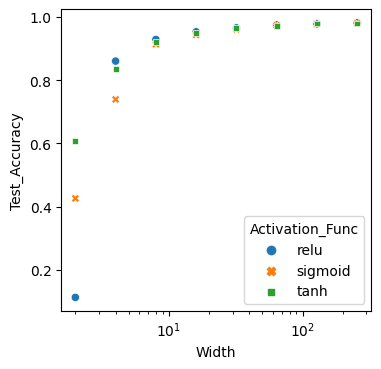

In [65]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
ax.set(xscale="log")
sns.scatterplot(data=df, x='Width', y='Test_Accuracy', hue='Activation_Func', style='Activation_Func');

With the two hidden layers of size 256 and using "relu" activation functions for each one, we achieve a testing accuracy of 98.1%. 

**Depth = 4**

Increase the depth of the NN to 4 and only consider widths from 4 to 64 this time. 

In [118]:
# HYPERPARAMETERS
NUM_EPOCHS = 20

# activation functions
act_func = ['relu', 'sigmoid', 'tanh']

# we will try to find the best hidden layer size from this list of options: 
hidden_layer_sizes = []
print("We will consider the following hidden layer sizes (width):")
for n in range (2, 7):
    width = 2 ** n
    print(width)
    hidden_layer_sizes.append(int(width))

We will consider the following hidden layer sizes (width):
4
8
16
32
64


In [69]:
all_width4 = []
all_func4 = []
all_loss4 = []
all_acc4 = []

for width in hidden_layer_sizes:
    for func in act_func:
        
        # store the parameters
        all_width4.append(width)
        all_func4.append(func)
        
        # model definition
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=input_size),         # input layer
            tf.keras.layers.Dense(width, activation=func),           # 1st hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 2nd hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 3rd hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 4th hidden layer
            tf.keras.layers.Dense(output_size, activation='softmax') # output layer
            ])
        
        # optimizer, loss function, and maetrics
        model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
        
        # training
        model.fit(train_data, 
          epochs=NUM_EPOCHS, 
          callbacks=early_stopping, 
          validation_data=(validation_inputs, validation_targets),
          verbose=2)
        
        # testing
        print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
        test_loss, test_acc = model.evaluate(test_data)
        all_loss4.append(test_loss)
        all_acc4.append(test_acc)

Epoch 1/20
540/540 - 15s - loss: 1.7498 - accuracy: 0.3196 - val_loss: 1.4022 - val_accuracy: 0.4483
Epoch 2/20
540/540 - 10s - loss: 1.2750 - accuracy: 0.5152 - val_loss: 1.2151 - val_accuracy: 0.5435
Epoch 3/20
540/540 - 13s - loss: 1.1357 - accuracy: 0.5938 - val_loss: 1.1054 - val_accuracy: 0.6067
Epoch 4/20
540/540 - 11s - loss: 1.0384 - accuracy: 0.6376 - val_loss: 1.0270 - val_accuracy: 0.6410
Epoch 5/20
540/540 - 12s - loss: 0.9702 - accuracy: 0.6679 - val_loss: 0.9694 - val_accuracy: 0.6703
Epoch 6/20
540/540 - 12s - loss: 0.9240 - accuracy: 0.6904 - val_loss: 0.9294 - val_accuracy: 0.6902
Epoch 7/20
540/540 - 13s - loss: 0.8891 - accuracy: 0.7146 - val_loss: 0.8917 - val_accuracy: 0.7153
Epoch 8/20
540/540 - 13s - loss: 0.8548 - accuracy: 0.7345 - val_loss: 0.8600 - val_accuracy: 0.7320
Epoch 9/20
540/540 - 11s - loss: 0.8256 - accuracy: 0.7474 - val_loss: 0.8318 - val_accuracy: 0.7430
Epoch 10/20
540/540 - 9s - loss: 0.8017 - accuracy: 0.7569 - val_loss: 0.8188 - val_accurac

540/540 - 11s - loss: 0.2680 - accuracy: 0.9226 - val_loss: 0.2953 - val_accuracy: 0.9140
Epoch 19/20
540/540 - 12s - loss: 0.2646 - accuracy: 0.9235 - val_loss: 0.2850 - val_accuracy: 0.9182
Epoch 20/20
540/540 - 12s - loss: 0.2598 - accuracy: 0.9247 - val_loss: 0.2895 - val_accuracy: 0.9165
testing model with hidden layer size of 8 and activation functions of relu
1/1 [==============================] - 2s 2s/step - loss: 0.3027 - accuracy: 0.9139
Epoch 1/20
540/540 - 16s - loss: 2.2398 - accuracy: 0.1958 - val_loss: 2.0339 - val_accuracy: 0.2363
Epoch 2/20
540/540 - 14s - loss: 1.7935 - accuracy: 0.3834 - val_loss: 1.5661 - val_accuracy: 0.4685
Epoch 3/20
540/540 - 13s - loss: 1.4009 - accuracy: 0.5305 - val_loss: 1.2845 - val_accuracy: 0.6068
Epoch 4/20
540/540 - 11s - loss: 1.1973 - accuracy: 0.6524 - val_loss: 1.1331 - val_accuracy: 0.6668
Epoch 5/20
540/540 - 13s - loss: 1.0728 - accuracy: 0.6910 - val_loss: 1.0446 - val_accuracy: 0.6958
Epoch 6/20
540/540 - 16s - loss: 0.9823 - 

Epoch 14/20
540/540 - 9s - loss: 0.2284 - accuracy: 0.9404 - val_loss: 0.2452 - val_accuracy: 0.9338
Epoch 15/20
540/540 - 12s - loss: 0.2210 - accuracy: 0.9414 - val_loss: 0.2439 - val_accuracy: 0.9337
Epoch 16/20
540/540 - 12s - loss: 0.2128 - accuracy: 0.9434 - val_loss: 0.2350 - val_accuracy: 0.9377
Epoch 17/20
540/540 - 11s - loss: 0.2063 - accuracy: 0.9453 - val_loss: 0.2347 - val_accuracy: 0.9340
Epoch 18/20
540/540 - 12s - loss: 0.2014 - accuracy: 0.9465 - val_loss: 0.2316 - val_accuracy: 0.9355
Epoch 19/20
540/540 - 12s - loss: 0.1954 - accuracy: 0.9479 - val_loss: 0.2258 - val_accuracy: 0.9387
Epoch 20/20
540/540 - 11s - loss: 0.1897 - accuracy: 0.9491 - val_loss: 0.2223 - val_accuracy: 0.9402
testing model with hidden layer size of 16 and activation functions of sigmoid
1/1 [==============================] - 2s 2s/step - loss: 0.2357 - accuracy: 0.9399
Epoch 1/20
540/540 - 13s - loss: 0.7580 - accuracy: 0.8102 - val_loss: 0.3592 - val_accuracy: 0.9045
Epoch 2/20
540/540 - 10

Epoch 16/20
540/540 - 12s - loss: 0.0381 - accuracy: 0.9885 - val_loss: 0.0874 - val_accuracy: 0.9728
Epoch 17/20
540/540 - 12s - loss: 0.0354 - accuracy: 0.9894 - val_loss: 0.0740 - val_accuracy: 0.9793
testing model with hidden layer size of 32 and activation functions of tanh
1/1 [==============================] - 1s 1s/step - loss: 0.1314 - accuracy: 0.9654
Epoch 1/20
540/540 - 14s - loss: 0.3661 - accuracy: 0.8896 - val_loss: 0.1897 - val_accuracy: 0.9447
Epoch 2/20
540/540 - 14s - loss: 0.1514 - accuracy: 0.9542 - val_loss: 0.1273 - val_accuracy: 0.9625
Epoch 3/20
540/540 - 10s - loss: 0.1125 - accuracy: 0.9658 - val_loss: 0.1094 - val_accuracy: 0.9678
Epoch 4/20
540/540 - 7s - loss: 0.0883 - accuracy: 0.9729 - val_loss: 0.1131 - val_accuracy: 0.9647
Epoch 5/20
540/540 - 8s - loss: 0.0763 - accuracy: 0.9770 - val_loss: 0.0848 - val_accuracy: 0.9758
Epoch 6/20
540/540 - 10s - loss: 0.0637 - accuracy: 0.9803 - val_loss: 0.0825 - val_accuracy: 0.9745
Epoch 7/20
540/540 - 11s - loss:

In [70]:
n4 = len(all_width4)
test_id4 = np.arange(1, n4+1, 1)

df4 = pd.DataFrame(data=test_id4, columns=["Test_ID"])
df4["Width"] = all_width4
df4["Activation_Func"] = all_func4
df4["Test_Loss"] = all_loss4
df4["Test_Accuracy"] = all_acc4

df4.sort_values(by="Test_Accuracy")

,Test_ID,Width,Activation_Func,Test_Loss,Test_Accuracy
1,2,4,sigmoid,1.148699,0.5601
2,3,4,tanh,0.670961,0.7723
0,1,4,relu,0.731848,0.7895
4,5,8,sigmoid,0.541442,0.8640
3,4,8,relu,0.302695,0.9139
5,6,8,tanh,0.261323,0.9277
7,8,16,sigmoid,0.235728,0.9399
6,7,16,relu,0.178691,0.9491
8,9,16,tanh,0.174120,0.9509
10,11,32,sigmoid,0.176028,0.9526


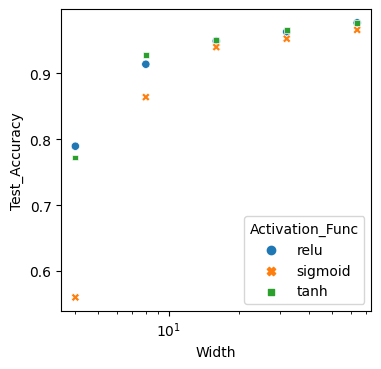

In [71]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
ax.set(xscale="log")
sns.scatterplot(data=df4, x='Width', y='Test_Accuracy', hue='Activation_Func', style='Activation_Func');

We achieved a max classification accuracy of 97.7% this time.

The activation functions of "relu" and "tanh" are better than "sigmoid" for every test. We can increase the width again and use one of these functions to see if the accuracy improves. 

In [120]:
func = 'relu'
width = 128

# model definition
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_size),         # input layer
    tf.keras.layers.Dense(width, activation=func),           # 1st hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 2nd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 3rd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 4th hidden layer
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
    ])

# optimizer, loss function, and maetrics
model.compile(optimizer='adam', 
      loss='sparse_categorical_crossentropy', 
      metrics=['accuracy'])

# training
model.fit(train_data, 
  epochs=NUM_EPOCHS, 
  callbacks=early_stopping, 
  validation_data=(validation_inputs, validation_targets),
  verbose=2)

# testing
print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
test_loss, test_acc = model.evaluate(test_data)

Epoch 1/20
540/540 - 3s - loss: 0.3043 - accuracy: 0.9087 - val_loss: 0.1557 - val_accuracy: 0.9562
Epoch 2/20
540/540 - 2s - loss: 0.1184 - accuracy: 0.9640 - val_loss: 0.1044 - val_accuracy: 0.9705
Epoch 3/20
540/540 - 2s - loss: 0.0802 - accuracy: 0.9752 - val_loss: 0.0850 - val_accuracy: 0.9738
Epoch 4/20
540/540 - 2s - loss: 0.0638 - accuracy: 0.9801 - val_loss: 0.0721 - val_accuracy: 0.9780
Epoch 5/20
540/540 - 2s - loss: 0.0500 - accuracy: 0.9839 - val_loss: 0.0870 - val_accuracy: 0.9748
Epoch 6/20
540/540 - 2s - loss: 0.0421 - accuracy: 0.9863 - val_loss: 0.0624 - val_accuracy: 0.9810
Epoch 7/20
540/540 - 2s - loss: 0.0369 - accuracy: 0.9879 - val_loss: 0.0584 - val_accuracy: 0.9817
Epoch 8/20
540/540 - 2s - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0537 - val_accuracy: 0.9827
Epoch 9/20
540/540 - 2s - loss: 0.0279 - accuracy: 0.9907 - val_loss: 0.0688 - val_accuracy: 0.9795
Epoch 10/20
540/540 - 2s - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.0626 - val_accuracy: 0.9833

**Testing Accuracy: 97.5%**

* Depth: 4 (number of layers in the NN)
* Width: 128 (hidden layer size)
* Activation Functions: rectified linear activation ("relu")

In [121]:
func = 'relu'
width = 256

# model definition
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_size),         # input layer
    tf.keras.layers.Dense(width, activation=func),           # 1st hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 2nd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 3rd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 4th hidden layer
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
    ])

# optimizer, loss function, and maetrics
model.compile(optimizer='adam', 
      loss='sparse_categorical_crossentropy', 
      metrics=['accuracy'])

# training
model.fit(train_data, 
  epochs=NUM_EPOCHS, 
  callbacks=early_stopping, 
  validation_data=(validation_inputs, validation_targets),
  verbose=2);

# testing
print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
test_loss, test_acc = model.evaluate(test_data)

Epoch 1/20
540/540 - 3s - loss: 0.2500 - accuracy: 0.9233 - val_loss: 0.1385 - val_accuracy: 0.9562
Epoch 2/20
540/540 - 3s - loss: 0.0986 - accuracy: 0.9700 - val_loss: 0.1118 - val_accuracy: 0.9658
Epoch 3/20
540/540 - 3s - loss: 0.0679 - accuracy: 0.9791 - val_loss: 0.0761 - val_accuracy: 0.9773
Epoch 4/20
540/540 - 3s - loss: 0.0523 - accuracy: 0.9836 - val_loss: 0.0734 - val_accuracy: 0.9795
Epoch 5/20
540/540 - 3s - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0628 - val_accuracy: 0.9820
Epoch 6/20
540/540 - 3s - loss: 0.0390 - accuracy: 0.9877 - val_loss: 0.0541 - val_accuracy: 0.9822
Epoch 7/20
540/540 - 3s - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.0484 - val_accuracy: 0.9848
Epoch 8/20
540/540 - 3s - loss: 0.0265 - accuracy: 0.9920 - val_loss: 0.0534 - val_accuracy: 0.9840
Epoch 9/20
540/540 - 3s - loss: 0.0254 - accuracy: 0.9921 - val_loss: 0.0452 - val_accuracy: 0.9877
Epoch 10/20
540/540 - 3s - loss: 0.0209 - accuracy: 0.9934 - val_loss: 0.0403 - val_accuracy: 0.9863

**Testing Accuracy: 98.1%**

* Depth: 4 (number of layers in the NN)
* Width: 256 (hidden layer size)
* Activation Functions: rectified linear activation ("relu")

**Depth = 8**

From the results above, it seems that we can remove the sigmoid activation function and exclude the hidden layer size of 4 and _include_ a width of 128. 

In [74]:
# HYPERPARAMETERS
NUM_EPOCHS = 20

# activation functions
act_func = ['relu', 'tanh']

# we will try to find the best hidden layer size from this list of options: 
hidden_layer_sizes = []
print("We will consider the following hidden layer sizes (width):")
for n in range (3, 8):
    width = 2 ** n
    print(width)
    hidden_layer_sizes.append(int(width))

We will consider the following hidden layer sizes (width):
8
16
32
64
128


In [75]:
all_width8 = []
all_func8 = []
all_loss8 = []
all_acc8 = []

for width in hidden_layer_sizes:
    for func in act_func:
        
        # store the parameters
        all_width8.append(width)
        all_func8.append(func)
        
        # model definition
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=input_size),         # input layer
            tf.keras.layers.Dense(width, activation=func),           # 1st hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 2nd hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 3rd hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 4th hidden layer
            tf.keras.layers.Dense(width, activation=func),           # 5
            tf.keras.layers.Dense(width, activation=func),           # 6
            tf.keras.layers.Dense(width, activation=func),           # 7
            tf.keras.layers.Dense(width, activation=func),           # 8
            tf.keras.layers.Dense(output_size, activation='softmax') # output layer
            ])
        
        # optimizer, loss function, and maetrics
        model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
        
        # training
        model.fit(train_data, 
          epochs=NUM_EPOCHS, 
          callbacks=early_stopping, 
          validation_data=(validation_inputs, validation_targets),
          verbose=0)
        
        # testing
        print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
        test_loss, test_acc = model.evaluate(test_data)
        all_loss8.append(test_loss)
        all_acc8.append(test_acc)

testing model with hidden layer size of 8 and activation functions of relu
1/1 [==============================] - 0s 352ms/step - loss: 0.3723 - accuracy: 0.8932
testing model with hidden layer size of 8 and activation functions of tanh
1/1 [==============================] - 0s 318ms/step - loss: 0.3045 - accuracy: 0.9180
testing model with hidden layer size of 16 and activation functions of relu
1/1 [==============================] - 0s 319ms/step - loss: 0.2219 - accuracy: 0.9405
testing model with hidden layer size of 16 and activation functions of tanh
1/1 [==============================] - 1s 537ms/step - loss: 0.1677 - accuracy: 0.9539
testing model with hidden layer size of 32 and activation functions of relu
1/1 [==============================] - 1s 679ms/step - loss: 0.1261 - accuracy: 0.9637
testing model with hidden layer size of 32 and activation functions of tanh
1/1 [==============================] - 0s 374ms/step - loss: 0.1280 - accuracy: 0.9649
testing model with hidde

**Randomize the Activation Functions**

In [125]:
# create a function to randomize the activation functions used in the deep NN
act_func = ['relu', 'sigmoid', 'tanh']
depth = 8
func_list = []

for layer in range(0, depth):
    fi = np.random.randint(low=0, high=3)
    func = act_func[fi]
    print(func)
    func_list.append(func)

relu
tanh
sigmoid
sigmoid
tanh
relu
tanh
sigmoid


In [113]:
# HYPERPARAMETERS
NUM_EPOCHS = 20

# activation functions
act_func = ['relu', 'tanh', 'sigmoid']

# we will try to find the best hidden layer size from this list of options: 
hidden_layer_sizes = []
print("We will consider the following hidden layer sizes (width):")
for n in range (4, 8):
    width = 2 ** n
    print(width)
    hidden_layer_sizes.append(int(width))

We will consider the following hidden layer sizes (width):
16
32
64
128


In [114]:
all_width_rand = []
all_func_rand = []
all_loss_rand = []
all_acc_rand = []

depth = 8

for width in hidden_layer_sizes:
    for i in range(0, 5):
        
        # generate random order of functions
        func_list = []
        for layer in range(0, depth):
            fi = np.random.randint(low=0, high=3)
            func = act_func[fi]
            func_list.append(func)
        
        # store the parameters
        all_width_rand.append(width)
        all_func_rand.append(func_list)
        
        # model definition
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=input_size),                 # input layer
            tf.keras.layers.Dense(width, activation=func_list[0]),           # 1st hidden layer
            tf.keras.layers.Dense(width, activation=func_list[1]),           # 2nd hidden layer
            tf.keras.layers.Dense(width, activation=func_list[2]),           # 3rd hidden layer
            tf.keras.layers.Dense(width, activation=func_list[3]),           # 4th hidden layer
            tf.keras.layers.Dense(width, activation=func_list[4]),           # 5
            tf.keras.layers.Dense(width, activation=func_list[5]),           # 6
            tf.keras.layers.Dense(width, activation=func_list[6]),           # 7
            tf.keras.layers.Dense(width, activation=func_list[7]),           # 8
            tf.keras.layers.Dense(output_size, activation='softmax')         # output layer
            ])
        
        # optimizer, loss function, and maetrics
        model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
        
        # training
        model.fit(train_data, 
          epochs=NUM_EPOCHS, 
          callbacks=early_stopping, 
          validation_data=(validation_inputs, validation_targets),
          verbose=0)
        
        # testing
        print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
        test_loss, test_acc = model.evaluate(test_data)
        all_loss_rand.append(test_loss)
        all_acc_rand.append(test_acc)

testing model with hidden layer size of 16 and activation functions of tanh
1/1 [==============================] - 0s 389ms/step - loss: 0.2801 - accuracy: 0.9276
testing model with hidden layer size of 16 and activation functions of tanh
1/1 [==============================] - 0s 421ms/step - loss: 0.2791 - accuracy: 0.9292
testing model with hidden layer size of 16 and activation functions of tanh
1/1 [==============================] - 0s 348ms/step - loss: 0.1973 - accuracy: 0.9457
testing model with hidden layer size of 16 and activation functions of sigmoid
1/1 [==============================] - 0s 455ms/step - loss: 0.2175 - accuracy: 0.9436
testing model with hidden layer size of 16 and activation functions of relu
1/1 [==============================] - 1s 581ms/step - loss: 0.2927 - accuracy: 0.9213
testing model with hidden layer size of 32 and activation functions of sigmoid
1/1 [==============================] - 1s 511ms/step - loss: 0.2998 - accuracy: 0.9226
testing model wi

In [115]:
n8 = len(all_width_rand)
test_id8 = np.arange(1, n8+1, 1)

df8 = pd.DataFrame(data=test_id8, columns=["Test_ID"])
df8["Width"] = all_width_rand
df8["Activation_Func"] = all_func_rand
df8["Test_Loss"] = all_loss_rand
df8["Test_Accuracy"] = all_acc_rand

df8.sort_values(by="Test_Accuracy")

,Test_ID,Width,Activation_Func,Test_Loss,Test_Accuracy
4,5,16,"[relu, sigmoid, tanh, relu, sigmoid, relu, tan...",0.292747,0.9213
5,6,32,"[sigmoid, sigmoid, sigmoid, tanh, relu, relu, ...",0.299809,0.9226
0,1,16,"[sigmoid, relu, sigmoid, tanh, relu, relu, rel...",0.280093,0.9276
1,2,16,"[tanh, relu, sigmoid, tanh, sigmoid, tanh, tan...",0.279057,0.9292
3,4,16,"[relu, relu, relu, relu, sigmoid, tanh, tanh, ...",0.217534,0.9436
2,3,16,"[relu, relu, relu, tanh, sigmoid, relu, relu, ...",0.197313,0.9457
7,8,32,"[tanh, relu, sigmoid, sigmoid, sigmoid, tanh, ...",0.233974,0.9462
12,13,64,"[tanh, sigmoid, relu, relu, sigmoid, tanh, sig...",0.167599,0.9563
9,10,32,"[tanh, relu, sigmoid, relu, tanh, tanh, relu, ...",0.152140,0.9594
8,9,32,"[relu, relu, relu, sigmoid, tanh, relu, tanh, ...",0.158423,0.9601


By randomly sampling the possible options for the activation functions and using a depth of 8, the best test accuracy was 97.5% for a hidden layer width of 128. We will do one more model with random and without random sampling of the activation functions but this time with a width of 256. 

In [126]:
depth = 8
width = 256
act_func = ['relu', 'tanh']  # remove sigmoid

for i in range(0, 3):
        
    # generate random order of functions
    func_list = []
    for layer in range(0, depth):
        fi = np.random.randint(low=0, high=2)
        func = act_func[fi]
        func_list.append(func)

    # model definition
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_size),                 # input layer
        tf.keras.layers.Dense(width, activation=func_list[0]),           # 1st hidden layer
        tf.keras.layers.Dense(width, activation=func_list[1]),           # 2nd hidden layer
        tf.keras.layers.Dense(width, activation=func_list[2]),           # 3rd hidden layer
        tf.keras.layers.Dense(width, activation=func_list[3]),           # 4th hidden layer
        tf.keras.layers.Dense(width, activation=func_list[4]),           # 5
        tf.keras.layers.Dense(width, activation=func_list[5]),           # 6
        tf.keras.layers.Dense(width, activation=func_list[6]),           # 7
        tf.keras.layers.Dense(width, activation=func_list[7]),           # 8
        tf.keras.layers.Dense(output_size, activation='softmax')         # output layer
        ])

    # optimizer, loss function, and maetrics
    model.compile(optimizer='adam', 
          loss='sparse_categorical_crossentropy', 
          metrics=['accuracy'])

    # training
    model.fit(train_data, 
      epochs=NUM_EPOCHS, 
      callbacks=early_stopping, 
      validation_data=(validation_inputs, validation_targets),
      verbose=0)

    # testing
    print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
    test_loss, test_acc = model.evaluate(test_data)

testing model with hidden layer size of 256 and activation functions of relu
1/1 [==============================] - 0s 464ms/step - loss: 0.1324 - accuracy: 0.9665
testing model with hidden layer size of 256 and activation functions of tanh
1/1 [==============================] - 0s 478ms/step - loss: 0.1142 - accuracy: 0.9727
testing model with hidden layer size of 256 and activation functions of tanh
1/1 [==============================] - 0s 445ms/step - loss: 0.1219 - accuracy: 0.9659


In [129]:
# specify the optimal parameters
width = 256
func = 'relu'

# model definition
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_size),         # input layer
    tf.keras.layers.Dense(width, activation=func),           # 1st hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 2nd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 3rd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 4th hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 5
    tf.keras.layers.Dense(width, activation=func),           # 6
    tf.keras.layers.Dense(width, activation=func),           # 7
    tf.keras.layers.Dense(width, activation=func),           # 8
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
    ])

# optimizer, loss function, and maetrics
model.compile(optimizer='adam', 
      loss='sparse_categorical_crossentropy', 
      metrics=['accuracy'])

# training
model.fit(train_data, 
  epochs=NUM_EPOCHS, 
  callbacks=early_stopping, 
  validation_data=(validation_inputs, validation_targets),
  verbose=2);

# testing
print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
test_loss, test_acc = model.evaluate(test_data)

Epoch 1/20
540/540 - 8s - loss: 0.2782 - accuracy: 0.9141 - val_loss: 0.1249 - val_accuracy: 0.9602
Epoch 2/20
540/540 - 7s - loss: 0.1229 - accuracy: 0.9645 - val_loss: 0.1264 - val_accuracy: 0.9608
Epoch 3/20
540/540 - 7s - loss: 0.0916 - accuracy: 0.9744 - val_loss: 0.1109 - val_accuracy: 0.9692
Epoch 4/20
540/540 - 7s - loss: 0.0717 - accuracy: 0.9801 - val_loss: 0.1070 - val_accuracy: 0.9692
Epoch 5/20
540/540 - 7s - loss: 0.0604 - accuracy: 0.9835 - val_loss: 0.1129 - val_accuracy: 0.9718
Epoch 6/20
540/540 - 6s - loss: 0.0547 - accuracy: 0.9848 - val_loss: 0.0640 - val_accuracy: 0.9825
Epoch 7/20
540/540 - 7s - loss: 0.0479 - accuracy: 0.9870 - val_loss: 0.0690 - val_accuracy: 0.9807
Epoch 8/20
540/540 - 7s - loss: 0.0418 - accuracy: 0.9890 - val_loss: 0.0869 - val_accuracy: 0.9785
testing model with hidden layer size of 256 and activation functions of relu
1/1 [==============================] - 1s 653ms/step - loss: 0.1188 - accuracy: 0.9709


In [130]:
# specify the optimal parameters
width = 256
func = 'tanh'

# model definition
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_size),         # input layer
    tf.keras.layers.Dense(width, activation=func),           # 1st hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 2nd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 3rd hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 4th hidden layer
    tf.keras.layers.Dense(width, activation=func),           # 5
    tf.keras.layers.Dense(width, activation=func),           # 6
    tf.keras.layers.Dense(width, activation=func),           # 7
    tf.keras.layers.Dense(width, activation=func),           # 8
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
    ])

# optimizer, loss function, and maetrics
model.compile(optimizer='adam', 
      loss='sparse_categorical_crossentropy', 
      metrics=['accuracy'])

# training
model.fit(train_data, 
  epochs=NUM_EPOCHS, 
  callbacks=early_stopping, 
  validation_data=(validation_inputs, validation_targets),
  verbose=2);

# testing
print("testing model with hidden layer size of {x} and activation functions of {y}".format(x=width, y=func))
test_loss, test_acc = model.evaluate(test_data)

Epoch 1/20
540/540 - 5s - loss: 0.3137 - accuracy: 0.9052 - val_loss: 0.2344 - val_accuracy: 0.9320
Epoch 2/20
540/540 - 4s - loss: 0.1777 - accuracy: 0.9485 - val_loss: 0.1608 - val_accuracy: 0.9550
Epoch 3/20
540/540 - 5s - loss: 0.1310 - accuracy: 0.9613 - val_loss: 0.1448 - val_accuracy: 0.9582
Epoch 4/20
540/540 - 7s - loss: 0.1107 - accuracy: 0.9673 - val_loss: 0.1101 - val_accuracy: 0.9700
Epoch 5/20
540/540 - 7s - loss: 0.0926 - accuracy: 0.9721 - val_loss: 0.1193 - val_accuracy: 0.9683
Epoch 6/20
540/540 - 7s - loss: 0.0764 - accuracy: 0.9768 - val_loss: 0.1325 - val_accuracy: 0.9632
testing model with hidden layer size of 256 and activation functions of tanh
1/1 [==============================] - 1s 691ms/step - loss: 0.1414 - accuracy: 0.9606
